# Simulating the Ecosystem

This document presents the first attempt at a comprehensive simulation of the Platform. The Platform allows for interactions between the research sponsors, users, and data scientists. The research sponsor will to recruit users to participate in studies, and data scientists to compete for the best model prediction.

This simulation is based on microeconomic foundations that are outlined in the accompanying pdf document. Simply speaking, when the research sponsor chooses user reward, in Nash Equilibrium he would choose the lowest reward that enough users will accept, which is the cost of taking the necessary tests. Similarly, the prize for data scientists should be comparable to their outside option, for example, other prizes on the same platform, or on other platforms.

In [1]:
import numpy as np
import random
import math
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.pyplot import figure
random.seed()

In [2]:
global_test_cost = np.array( [10, 12.5, 15, 100, 200, 300, 400, 800, 2500] )

Since we are simulating the economy in time, we need to add some concept of time, as well as impatience parameter for all involved parties. We will use standard exponential discounting with parameter $\rho$. 

In [3]:
global rho
rho = 0.0001

def discount_time(delta_time):
    return math.exp(-rho*delta_time)

Our first object is the platform itself. The platform has users and data scientists waiting for research sponsors. There are 9 types of possible (omics) data, and for a user to obtain each data point, she needs to take a test. Some tests are very cheap, some are very expensive. The platform has an option to enforce a minimum payment (from research sponsor to a user), which may be desirable to attract new users. We also assume that the least active user checks her phone (therefore learning about the current studies) at least once every 30 days.

In [4]:
class Platform:
    def __init__(self,U,DS):
        self.total_users = U
        self.total_ds = DS
        self.test_cost = global_test_cost
        self.total_tests = len(self.test_cost)
        self.tests = np.arange(self.total_tests)
        self.min_payment = 15
        self.max_delay = 30

The next object is a user. Each user is characterized by the tests she has taken, her balance, and how active she is on the platform. If, at some point, she decides to take some test, then she obtains the results and is considered to possess that type of data forever. Users are rational in a sense that that can perfectly calculate the cost of taking the tests they hadn't taken yet, and decide whether it's worth it to participate in any proposed study, given it's reward.

User's activity parameter reflects how often the user checks the app on her phone, and therefore learns about new studies. The lower the parameter, the more active the user is. Of course, it is still possible that the least active user still learns about some studies first, just because she happened to check her phone the day it was announced.

In [5]:
class User:
    
    def __init__(self,activity):
        self.tests_taken = np.zeros(p.total_tests)
        self.balance = 0
        self.activity = activity # how often user checks phone, at most # days
    # user calculates the cost of taking tests, we pass them a list like [1 2 9]
    
    def cost_of_tests(self,tests):
        cost = 0
        for t in tests:
            cost += ( 1 - self.tests_taken[t-1] ) * p.test_cost[t-1]
        return cost
    
    # when user takes tests, she pays the cost and her data is updated
    def takes_tests(self,tests):
        cost = self.cost_of_tests(tests)
        self.balance -= cost
        for t in tests:
            self.tests_taken[t-1] = 1
            
    # when user decides to participate in a study, she compares cost vs. reward
    def decides_to_participate(self,tests,reward):
        cost = self.cost_of_tests(tests)
        return reward >= cost
    
    def gets_paid(self,amount):
        self.balance += amount
        
    def willingness_to_accept(self,tests,r,delta1,delta0):
        # delta1 is discount until the end (learning results of the study)
        # delta0 is discount until user gets paid
        # user accepts if delta0*reward + delta1*r - cost >= outside_option
        # rearranging, we get reward >= (o_o + cost - delta1*r)/delta0
        cost = self.cost_of_tests(tests)
        return ( cost - delta1*r )/delta0

We also have data scientists. Each data scientist is characterized by his ability and his balance. When a data scientist participates in a competition, he submits a solution every $10$ days. Solutions are drawn from the uniform distribution, and are positively correlated with the data scientist's ability.

In [6]:
class Data_Scientist(object):
    
    def __init__(self, ability):
        self.balance = 0
        self.ability = ability
        
    def submit_solution(self,time):
        attempts = time // 10                                     # assume a solution is generated every 10 days
        model = np.random.uniform(0,self.ability,attempts)
        return max(model)
    
    def gets_paid(self,amount):
        self.balance += amount

Perhaps the most complex object we have is the research sponsor. Each research sponsor requires $N$ user participants, a particular set of required tests, wants the data science competition to last $\tau$ days, and would like to recruit users in $\delta$ days.

The first thing that the research sponsor can do is calculate user reward. To do so, the research sponsor first calculates every user's "willingness to accept" (WTA), the lowest possible reward that would make it worthwhile for the user to pay the costs of all required tests that she hasn't taken yet, and participate in the study. Then, since the research sponsor wants to minimize total budget, he would choose the prize to be the $N$th smallest WTA, and exactly $N$ users (which is the number the research sponsor wants) will participate. This would be the scenario had the research sponsor been very patient: after all, one of these $N$ users with the lowest WTA could be really inactive, and it would take forever for her to check her phone. If the research sponsor wants to speed things up (if his $\delta$ is less than 30), then he would increase the offered reward proportionally to his expectation of how many users will be checking their phones in the requested time interval.

Once the reward is chosen, user recruitment begins. First, we generate, based on user activity, the delay with which every user will hear about the study. Then, every user who hear about the study, decides to participate by comparing her WTA to the reward, and accepts if the latter is higher.

The prize for the data science competition, for now, is chosen to be on par with the outside option of the contestants, which is normalized to be \$$1000$. 

The arguments used in the last two paragraphs are presented in a more formal game-theoretic setting in the accompanying pdf document. These are the Nash Equilibrium strategies of the players.

In [7]:
class Research_Sponsor:
    
    def __init__(self,N,req_t,r,delta,tau):
        self.required_users = N
        self.required_tests = req_t
        self.delta = delta
        self.r = r
        self.delta1 = discount_time(delta + tau)       # discount until learning results of the study
        self.delta0 = discount_time(delta)             # discount until getting paid
        self.budget = 0
        self.tau = tau
        
    def calculate_user_WTA(self):
        
        # here we calculate every user's willingness to accept a research project
        # WTA is minimum payment that will make it profitable to participate in the study,
        # given that some tests the user will probably have to pay for
        WTA = np.zeros(p.total_users)
        for i in range(p.total_users):
            WTA[i] = user[i].willingness_to_accept(self.required_tests,self.r,self.delta1,self.delta0)
        return WTA
    
    def choose_user_reward(self):
        
        # the research sponsor chooses the reward based on every user's WTA as well as own patience
        WTA = self.calculate_user_WTA()
        
        # ideally the RS would like to pay as little as possible -- then he targets those users with lowest WTA
        WTA_desc = np.sort(WTA) 
        
        # sometimes the RS is impatient, then he targets a wider pool, in increasing order of WTA
        ind = min(p.total_users-1,(self.required_users-1)*p.max_delay//self.delta)
        
        d = max(WTA_desc[ind],p.min_payment)
        return d
    
    # announcing the study lets users learn about it (with time)
    def recruit_users(self,d):
        
        user_delay = np.zeros(p.total_users)
        WTA = np.zeros(p.total_users)
        for i in range(p.total_users):
            user_delay[i] = np.random.rand()*user[i].activity # day at which each user learns about the study
            WTA[i] = user[i].willingness_to_accept(self.required_tests,self.r,self.delta1,self.delta0)
        qual_users = np.where(WTA<=d)
        sorted_delay = user_delay.argsort()
        possible_participants = sorted_delay[ np.isin(sorted_delay,qual_users) ]
        participants = possible_participants[0:self.required_users]
        required_time = user_delay[participants[-1]]
        return (participants,user_delay,required_time) # return indices of participants
    
    def pay_users(self,amount,which_users):
        
        self.budget -= len(which_users)*amount
        
    def pay_data_scientists(self,amount,which_ds):
        
        self.budget -= len(which_ds)*amount
        
    def run_ds_competition(self,submissions):
        
        best_model = submissions.max()
        winner = submissions.argmax()
        return (winner, best_model)
    
    def choose_DS_prize(self):
        
        o = 1000;
        return self.tau*o / (30*discount_time(self.tau))

### The first research project, ever

Suppose the platform was just launched. There are 250 pre-registered users, none of whom have taken any tests yet. A research sponsor enters. He needs 50 users recruited over 30 days, requires tests 1, 2, and 3, and would like the data science competition to run 60 days.

First of all, let us generate the platform.

In [8]:
p = Platform(250,100)                                     # set up platform for the first time

Next we initiate the users. The users do not possess any data and their balances are zero. User's activity parameter is a random integer between 1 (checks phone every day) and 30 (checks phone once a month).

In [9]:
# generate users on the platform

user = []
user_activity = np.random.randint(1, p.max_delay, size = p.total_users)

for i in range(p.total_users):
    u = User( user_activity[i] )
    user.append(u)

Similarly, we introduce the data scientists. We draw their ability parameter from the uniform distribution, and it can be between $1$ and $2$.

In [10]:
ds_ability = np.random.uniform(1,2,p.total_ds)

# generate data scientists on the platform

data_scientist = []
for j in range(p.total_ds):
    ds = Data_Scientist(ds_ability[j])
    data_scientist.append(ds)

Then, we introduce the first research sponsor, ever.

In [11]:
N         = 50                                            # required number of user participants
req_tests = np.array([1,2,3])                             # list of required data (tests)
r         = 0                                             # non-monetary benefit to users
delta     = 30                                            # user recruitment period target (from 1 to 30)
tau       = 60                                            # duration of the data science competition

rs = Research_Sponsor(N,req_tests,r,delta,tau)

Now that we've introduced all the players, we can run the whole project.

In [12]:
# First full research project

# user recruitment

d = rs.choose_user_reward()
(participants,user_delay,required_time) = rs.recruit_users(d)
rs.pay_users(d,participants)
for i in participants:
    user[i].takes_tests(req_tests)
    user[i].gets_paid(d)
    
# data science competition
    
ds_submissions = np.zeros(p.total_ds)
for j in range(p.total_ds):
    ds_submissions[j] = data_scientist[j].submit_solution(tau)
(w,m) = rs.run_ds_competition(ds_submissions)

Let us first take a look at the user recruitment process. We are interested in how active users are, how long it takes them to actually learn about the project, what the offered reward is, and which users end up in the study

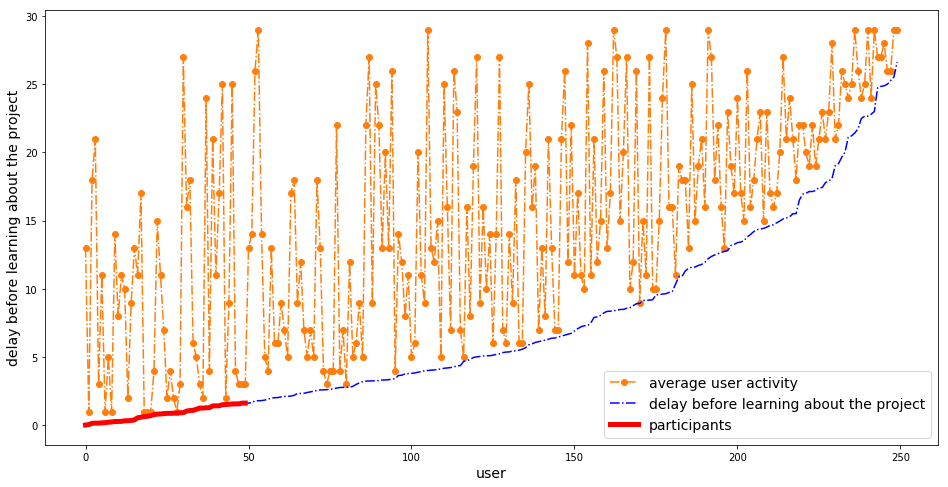

In [13]:
fig, (ax0) = plt.subplots(1,1, figsize=(16,8))

ax0.plot( user_activity[np.argsort(user_delay)], 'ko-.', color = '#ff7f0e' )
ax0.plot( np.sort(user_delay), 'b-.' );
ax0.plot( user_delay[participants], 'r',linewidth=5 );

ax0.set_xlabel("user", fontsize = 14);
ax0.set_ylabel("delay before learning about the project", fontsize = 14);
ax0.legend(('average user activity', 'delay before learning about the project', 'participants'), loc=4, fontsize = 14);

An obvious outtake from this picture is that at the platform inception, the first $N$ users who hear about the project will participate. This is because none of the users have any data yet, so all users' WTA are the same, and they will all accept the same reward, as long as it covers the cost of taking tests. Also, on average more active users have a better chance at getting selected, but less active users have a chance, too, if they are lucky enough to check their phone at the right time.

In [14]:
print ("the user reward is ", d)
print ("user recruitment lasted ", required_time, " days")

the user reward is  37.612668918876636
user recruitment lasted  1.6295437864883182  days


The user reward ends up being a little higher than the total cost of tests (10 + 12.5 + 15 = 37.5) to account for future value discounting. User recruitment takes barely any time since any user wants to participate, so we just need to wait until enough users learn about the study.

Next let up take a look at the data scientists. Recall that each data scientists has an ability parameter between $1$ and $2$, and every $10$ days until the competition ends he submits a solution, which is a random draw from $0$ to his ability level. 

In [15]:
sorted_ability = np.sort(-ds_ability)
ind = np.where(sorted_ability == -ds_ability[w])[0]
print ("the winner is the data scientist number ", w)
print ("his ability rank is ", ind+1)
print ("his prize is ", rs.choose_DS_prize() )

the winner is the data scientist number  31
his ability rank is  [3]
his prize is  2012.0360721081297


We can see that the prize equals approximately \$$2000$, since \$$1000$ is the market rate for a month of work, and the competition lasted $60$ days. The graph below illustrates all data scientists and their best submissions, as well as the winner.

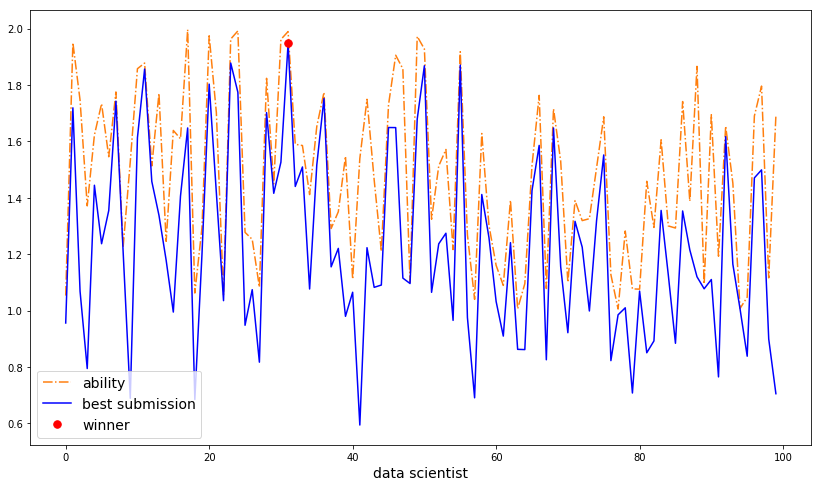

In [16]:
fig, (ax0) = plt.subplots(1,1, figsize=(14,8))

ax0.plot( ds_ability, '-.', color = '#ff7f0e');
ax0.plot( ds_submissions, 'b');
ax0.plot( w, ds_submissions[w], 'ro', markersize = 7.5 );
ax0.set_xlabel("data scientist", fontsize = 14);
ax0.legend(('ability', 'best submission', 'winner'), loc=3, fontsize = 14);

### Recommended budget for a Research Sponsor

Suppose a research sponsor reaches out to the Platform to inquire how much it would cost to run a data trial. This research sponsor needs $25$ participants, wants the data competition to run $30$ days, and would like to recruit the users as soon as possible. The results of this study would be completely private, so there is no non-monetary benefit for the users to participate. The data required for this trial is the three cheapest and most common tests $1$, $2$, $3$, and a reasonably-priced test $6$. 

In [17]:
N = 25
tau = 30
delta = 30
r = 0
req_tests = np.array([1,2,3,6])
rs = Research_Sponsor(N, req_tests, r, delta, tau)

The research sponsor would like to know what budget would be required to conduct such data trial on the Platform. It would cost more than 25*(10 + 12.5 + 15 + 300) to recruit the users and pay for their test results if the platform isn't used.

We would like to ask this question for different degrees of the platform maturity. At launch, it is pretty clear that the research sponsor would have to compensate the users for taking all tests in full, as we showed in the exercise above. However, if this research sponsor enters the platform once it's more established, there is a chance that there will already be users who have collected the necessary data previously, in which case their data will be much cheaper.

How do we know which tests users will have taken one, two, three months into the future? We do not. In our simulation, we will be using a method analogous to Monte Carlo simulation. For every maturity level of the platform (measured in months since its conception), we simulate 250 random paths of development, and then we see how well the research sponsor in question can do on all of these paths.

In [18]:
num_sim = 250
max_maturity = 24

user_reward = np.zeros((num_sim,max_maturity+1))

# when RS enters the platfom at its inception, there is no history

# generate users on the platform

user_activity = np.random.randint(1, p.max_delay, size = p.total_users)
user = []
for i in range(p.total_users):
    u = User( user_activity[i] )
    user.append(u)

# generate data scientists on the platform

data_scientist = []
for j in range(p.total_ds):
    ds = Data_Scientist(ds_ability[j])
    data_scientist.append(ds)
    
user_reward[:,0] = rs.choose_user_reward()

for months_old in range(1, max_maturity + 1):
    
    # for every level of maturity, we generate histories many times
    for sim in range(num_sim):
        
        # every history start at launch when there's nothing
        # generate users on the platform
        
        user = []
        user_activity = np.random.randint(1, p.max_delay, size = p.total_users)
        for i in range(p.total_users):
            u = User( user_activity[i] )
            user.append(u)

        # generate data scientists on the platform
        data_scientist = []
        for j in range(p.total_ds):
            ds = Data_Scientist(ds_ability[j])
            data_scientist.append(ds)
    
        # if the platform is months_old, it has had months_old projects on it already
        for m in range(months_old):
            # generate one random research sponsor, and go through the whole project
            sim_N = np.random.randint(5, p.total_users/10)
            sim_tau = np.random.randint(30,120)
            sim_delta = np.random.randint(20,30)
            sim_r = 0
            sim_req_tests = np.random.choice(p.tests, np.random.randint(1,p.total_tests), replace=False)+1
            sim_rs = Research_Sponsor(sim_N,sim_req_tests,sim_r,sim_delta,sim_tau)
            sim_d = sim_rs.choose_user_reward()
            (sim_part,ud,rt) = sim_rs.recruit_users(sim_d)
            sim_rs.pay_users(sim_d,sim_part)
            for sp in sim_part:
                user[sp].takes_tests(sim_req_tests)
                user[sp].gets_paid(sim_d)
                
        # now we have a history, let's add our research sponsor
        user_reward[sim,months_old] = rs.choose_user_reward()

What we are really interested in is the evolution of user reward for this particular study as the platform ages.

In [19]:
mean_d = np.mean(user_reward,axis=0)

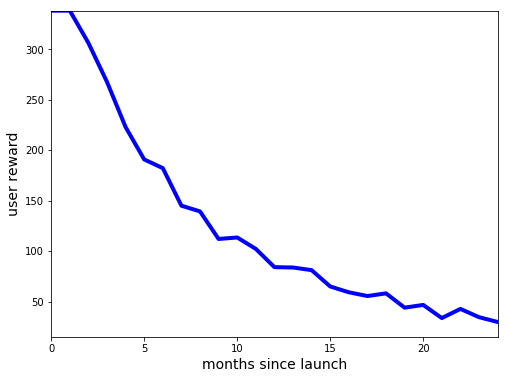

In [20]:
fig, ax = plt.subplots(1,1, figsize=(8,6))
ax.set_xlabel("months since launch", fontsize = 14)
ax.set_ylabel("user reward", fontsize = 14)

months = np.arange(max_maturity + 1)

plt.xlim( 0, max_maturity )
plt.ylim( p.min_payment, user_reward[0,0] )
ax.plot( months, mean_d, 'b',linewidth = 4 );

plt.savefig('RS_user_reward.pdf')

We can see that the user reward drops sharply as platform ages. In a year, it drops 5 times! This is a very optimistic result, but it's important to bear in mind that these calculations are done on average, for a large number of simulations. In reality, more expensive tests will likely be used much less frequently, and it will take much longer for a significant drop in a user reward.

### How are Data Scientists doing?

Let us now turn our attention to the data science competition aspect of the platform. Ideally, the Platform would like to both attract the best data scientists in the world (so that the research sponsors get the best model predictions), as well achieve a reasonable level of competitiveness of the new and learning contestants. Let us see how our assumptions are doing in terms of these two things.

We would use a simulation method similar to one used above. We will start at launch, and simulate 12 months worth of research projects (and hence data science competitions), 100 times. We will then average every data scientist's earnings over each of those 100 runs of the economy to see the correlation between ability and annual earnings.

In [21]:
num_sim = 100
maturity = 12 # now we are considering histories of lenghth of one year only

ds_annual_income = np.zeros((num_sim,p.total_ds))
win_counter = np.zeros((num_sim,p.total_ds))

# generate users on the platform

user = []
user_activity = np.random.randint(1, p.max_delay, size = p.total_users)
for i in range(p.total_users):
    u = User( user_activity[i] )
    user.append(u)

# generate data scientists on the platform, fix their ability level across simulations

ds_ability = np.random.uniform(1,2,p.total_ds)
data_scientist = []

for j in range(p.total_ds):
    
    ds = Data_Scientist(ds_ability[j])
    data_scientist.append(ds)

for sim in range(num_sim):
        
    # every history start at launch when there's nothing
    # generate users on the platform
    
    user = []
    user_activity = np.random.randint(1, p.max_delay, size = p.total_users)
    for i in range(p.total_users):
        u = User( user_activity[i] )
        user.append(u)

    # generate data scientists on the platform
    
    data_scientist = []
    for j in range(p.total_ds):
        ds = Data_Scientist(ds_ability[j])
        data_scientist.append(ds)
    
    # generate a history
    
    for m in range(maturity):
        
        # generate one random research sponsor, and go through the whole project
        
        sim_N = np.random.randint(5, p.total_users/10)
        sim_tau = 30 # now we fix every competition at 30 days
        sim_delta = np.random.randint(20,30)
        sim_r = 0
        sim_req_tests = np.random.choice(p.tests, np.random.randint(1,p.total_tests), replace=False)+1
        sim_rs = Research_Sponsor(sim_N,sim_req_tests,sim_r,sim_delta,sim_tau)
        
        # we can ignore user recruitment since it's irrelevant for DS competitions
        
        #sim_d = sim_rs.choose_user_reward()
        #(sim_part,ud,rt) = sim_rs.recruit_users(sim_d)
        #sim_rs.pay_users(sim_d,sim_part)
        #for sp in sim_part:
        #    user[sp].takes_tests(sim_req_tests)
        #    user[sp].gets_paid(sim_d)
            
        # important part -- running the DS competition
        
        ds_submissions = np.zeros(p.total_ds)
        
        for j in range(p.total_ds):
            ds_submissions[j] = data_scientist[j].submit_solution(sim_tau)
            
        (w,m) = sim_rs.run_ds_competition(ds_submissions)
        prize = sim_rs.choose_DS_prize()
        data_scientist[w].gets_paid(prize)
        win_counter[sim,w] += 1
    
    for j in range(p.total_ds):
        ds_annual_income[sim,j] = data_scientist[j].balance

We will be tracking data scientists' incomes and the number of competitions won.

In [22]:
mean_ds_annual_income = np.mean(ds_annual_income,axis=0)
mean_win_counter = np.mean(win_counter,axis=0)

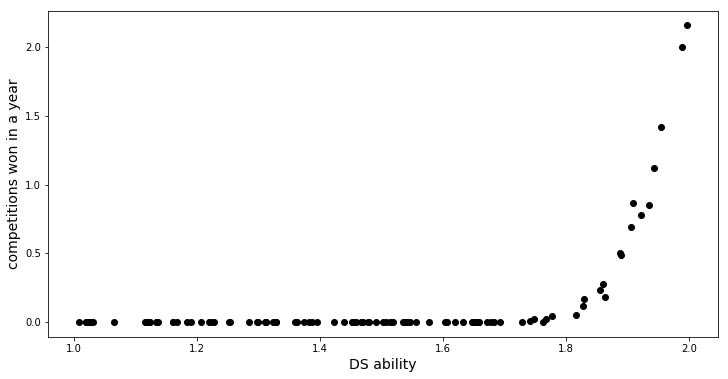

In [23]:
fig, (ax1) = plt.subplots(1,1, figsize=(12,6))

ax1.set_xlabel("DS ability", fontsize = 14)
ax1.set_ylabel("competitions won in a year", fontsize = 14)
ax1.plot( ds_ability, mean_win_counter, 'ko' );

The graph shows how many competitions the data scientists win on average in a year, depending on their ability. We can see that there is a strong positive correlation between ability and winning, yet a good fraction of data scientists have a chance at winning something, and the fraction of data scientists that make over $1000 a year (which is assumed to be their monthly income otherwise) is not insignificant:

In [24]:
print ("number of DS with positive balance after a year: ", len(np.argwhere(mean_ds_annual_income>0)))
print ("number of DS with balance over $1000 after a year: ", len(np.argwhere(mean_ds_annual_income>1000)))

number of DS with positive balance after a year:  20
number of DS with balance over $1000 after a year:  4


### How much income should Users reasonably expect?

Let us now turn our attention towards users. At the launch date, we assumed there are 250 pre-registed users. To understand how much money each user can reasonably expect to make per month, we simulate 100 random runs of the economy since its inception for up to two years. The reason why we need so many is because ex-ante users have no idea which studies will be available, and how soon they will learn about them.

In [25]:
max_maturity = 24
num_sim = 50
mean_final_balance = np.zeros( (max_maturity, p.total_users) )
user_activity = p.max_delay*np.ones(p.total_users) # this is fixed across in this simulation
  
for months_old in range(max_maturity):
    
    user_balance = np.zeros((num_sim, p.total_users))

    # for every level of maturity, we generate histories many times
    
    for sim in range(num_sim):
    
        # resetting user balances and tests taken, but not the activity parameter
        user = []
        for i in range(p.total_users):
            u = User( user_activity[i] )
            user.append(u)

        # reset data scientists
        data_scientist = []
        ds_ability = np.random.uniform(1,2,p.total_ds)
        for j in range(p.total_ds):
            ds = Data_Scientist(ds_ability[j])
            data_scientist.append(ds)
        
        # generating history of length months_old
        
        for m in range(months_old):
            # generate one random research sponsor, and go through the whole project
            sim_N = np.random.randint(5, p.total_users/10)
            sim_tau = np.random.randint(30,120)
            sim_delta = np.random.randint(20,30)
            sim_r = 0
            sim_req_tests = np.random.choice(p.tests, np.random.randint(1,p.total_tests), replace=False)+1
            sim_rs = Research_Sponsor(sim_N,sim_req_tests,sim_r,sim_delta,sim_tau)
            sim_d = sim_rs.choose_user_reward()
            (sim_part,ud,rt) = sim_rs.recruit_users(sim_d)
            sim_rs.pay_users(sim_d,sim_part)
            for sp in sim_part:
                user[sp].takes_tests(sim_req_tests)
                user[sp].gets_paid(sim_d)
                
        for i in range(p.total_users):
            user_balance[sim,i] = user[i].balance
        
    mean_final_balance[months_old,:] = np.mean(user_balance, axis=0)

Let us plot how the user balance evolves as the platform matures. Because there are so many simulations, we will have a huge spread of earnings, and to make the graph more informative, we will label users with similar activity levels with the same color. We also draw the "minimum payment line", which reflects user's earnings if he was paid the minimum payment every month.

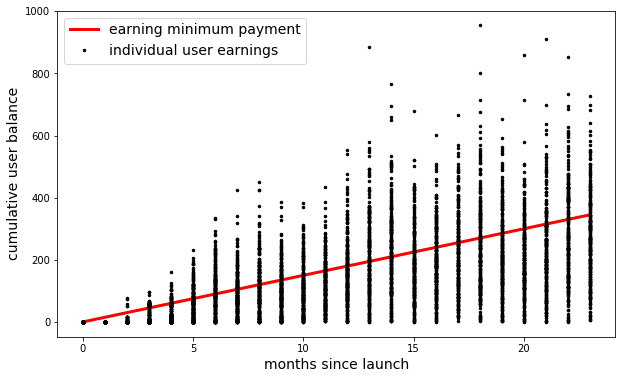

In [26]:
months = np.arange(max_maturity)
fig, (ax1) = plt.subplots(1,1, figsize=(10,6))

ax1.set_xlabel("months since launch", fontsize = 14);
ax1.set_ylabel("cumulative user balance", fontsize = 14);

ax1.plot( months, months*p.min_payment, 'r-', linewidth = 3 );
ax1.plot(months, mean_final_balance, 'ko', markersize = 2.5 );

ax1.legend(('earning minimum payment','individual user earnings'), loc = 0, fontsize = 14);

plt.savefig('user_earnings.pdf')

~~~

### A Superstar patient

Imagine now that at the platform inception there is one user who is a "superstar": he has already previously taken the super expensive test #9. How well can he reasonably expect to do? We run the exact same simulation as above, with the exception that all users start with no tests, except for user #1.

In [27]:
max_maturity = 24
num_sim = 50
mean_final_balance = np.zeros((max_maturity, p.total_users))
    
for months_old in range(max_maturity):
    
    user_balance = np.zeros((num_sim, p.total_users))

    # for every level of maturity, we generate histories many times
    for sim in range(num_sim):
    
        # resetting user balances and tests taken, but not activity
    
        user = []
        user_activity = np.random.randint(1, p.max_delay, size = p.total_users)
        
        for i in range(p.total_users):
            u = User( user_activity[i] )
            user.append(u)
            
        user[0].tests_taken[-1] = 1    # user 1 has taken test 9 in every simulation

        # reset data scientists
    
        data_scientist = []
        ds_ability = np.random.uniform(1,2,p.total_ds)
        for j in range(p.total_ds):
            ds = Data_Scientist(ds_ability[j])
            data_scientist.append(ds)
        
        # generating history of length months_old
        
        for m in range(months_old):
            # generate one random research sponsor, and go through the whole project
            sim_N = np.random.randint(5, p.total_users/10)
            sim_tau = np.random.randint(30,120)
            sim_delta = np.random.randint(20,30)
            sim_r = 0
            sim_req_tests = np.random.choice(p.tests, np.random.randint(1,p.total_tests), replace=False)+1
            sim_rs = Research_Sponsor(sim_N,sim_req_tests,sim_r,sim_delta,sim_tau)
            sim_d = sim_rs.choose_user_reward()
            (sim_part,ud,rt) = sim_rs.recruit_users(sim_d)
            sim_rs.pay_users(sim_d,sim_part)
            for sp in sim_part:
                user[sp].takes_tests(sim_req_tests)
                user[sp].gets_paid(sim_d)
                
        for i in range(p.total_users):
            user_balance[sim,i] = user[i].balance
        
    mean_final_balance[months_old,:] = np.mean(user_balance, axis = 0)

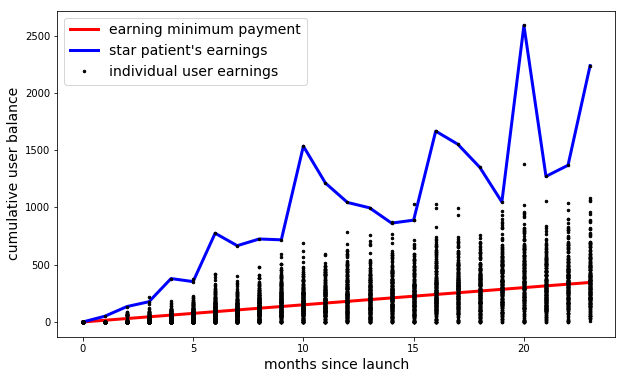

In [28]:
months = np.arange(max_maturity)
fig, (ax1) = plt.subplots(1,1, figsize=(10,6))

ax1.set_xlabel("months since launch", fontsize = 14);
ax1.set_ylabel("cumulative user balance", fontsize = 14);

ax1.plot( months, months*p.min_payment, 'r-', linewidth = 3 );
ax1.plot( months, mean_final_balance[:,0], 'b-', linewidth = 3 );
ax1.plot( months, mean_final_balance, 'ko', markersize = 2.5 );

ax1.legend(('earning minimum payment','star patient\'s earnings', 'individual user earnings'), loc = 0, fontsize = 14);

plt.savefig('user_earnings_superstar.pdf')

Evidently, the superstar patient will do really well on average, much better than all other users, and much better than receiving the minimum payment once a month. This is a very compelling argument for people with rare conditions to join the Platform early. Of course, there is no guarantee that a research sponsor that requires rare data will appear on the platform right away, or even ever, but even a small chance of that happening promises a lot of money. In the meantime, such user can participate in cheaper studies along with others.

## Concluding remarks

This document introduced a PYTHON program code that can be used to simulate the Platform performance once it's launched. All agents make decisions strategically, and the outcome of all interactions is a Nash Equilibrium.

This code can be used to simulate just about anything that can happen on the platform, and to demonstrate this applicability we show how to
- recommend a per-user price of study to the research sponsor, in order to minimize his budget and minimize the time of recruitment,
- model the data science competition
- predict future earnings of platform users, including cases when they possess some special data.

The model was written using some very special assumptions, which are fully customizable. Most notably, we are using 250 users and 100 data scientists, we only have 9 types of omics data, and prices of tests are fixed at particular values for the time-being.

In the current version, the main limitations are
- the user base is fixed,
- the number of data scientists is fixed,
- research projects arrive exactly once a month.

The first two points, while unfortunate, are not that restrictive: one can treat the number of users as the upper bound on the platform size, in which case the code will still apply as long as the platform has enough users for every research study. However, it is definitely a priority to add some concept of platform size evolution.

The assumption about research sponsors arriving once a month is for convenience only and can be replaced with any reasonable estimate of the frequency of their arrival.